In [1]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')
nltk.download('stopwords')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import csv

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm
from textblob import TextBlob
from scipy.special import softmax


plt.style.use('ggplot')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\devio\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\devio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\devio\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\devio\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\devio\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\devio\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is alr

In [2]:
# Read in data
file_name = 'staroutput'
working_file_name = file_name + ".csv"

try:
    df = pd.read_csv(working_file_name, encoding='utf-8')
except UnicodeDecodeError:
    try:
        df = pd.read_csv(working_file_name, encoding='ISO-8859-1')
    except UnicodeDecodeError:
        df = pd.read_csv(working_file_name, encoding='cp1252')

In [3]:
df.head()

,MsgID,Timestamp,Author,ThreadID,ThreadTitle,MsgBody,ReplyTo,Permalink
0,'kyh1ir9','2024-04-07 07:27:08','Apprehensive_Wave747','1bxz1bs','BMK 12v to 110v AC inverter to power starlink...,'Thank you so much. Iâll be ordering that. I...,'kyg88am','/r/Starlink/comments/1bxz1bs/bmk_12v_to_110v_...
1,'kyh2b0z','2024-04-07 07:32:16','n3fyi','1by5bj5','We live in SE Oklahoma about 1/2 from the lin...,'Itâs not going to last all day. Just deal w...,'-','/r/Starlink/comments/1by5bj5/we_live_in_se_ok...
2,'kyh30bd','2024-04-07 07:36:52','Blowfish75','1bvsdp1','Starlink Maps Updates!','Not sure what you are trying to say but most ...,'ky1new5','/r/Starlink/comments/1bvsdp1/starlink_maps_up...
3,'kyh36dk','2024-04-07 07:37:58','libertysat','1bxulgs','Watching more satellites go into service from...,'Exactly what I saw from my back yard last nig...,'-','/r/Starlink/comments/1bxulgs/watching_more_sa...
4,'kyh375z','2024-04-07 07:38:07','SuriPolomareFan2003','1bxvxz3','About Starlink in Venezuela','But yes Starlink for us but unofficial.','kygot0q','/r/Starlink/comments/1bxvxz3/about_starlink_i...


In [4]:
#Preprocess the Text
input_csv = pd.read_csv(working_file_name, encoding='ISO-8859-1')
messages = input_csv['MsgBody']
msg_ids = input_csv['MsgID']

In [5]:
def text_processing(message):
    def form_sentence(message):
        message_blob = TextBlob(message.lower())  # Convert to 'textblob'
        return ' '.join(message_blob.words)
    
    def no_user_alpha(message):
        message_list = [item for item in message.split()]
        clean_words = [word for word in message_list if re.match(r'[^\W\d]*$', word)]
        clean_sentence = ' '.join(clean_words)
        clean_mess = [word for word in clean_sentence.split() if word not in stopwords.words('english')]
        return clean_mess
    
    def normalization(message_list):
        lem = WordNetLemmatizer()
        normalized_message = []
        for word in message_list:
            normalized_text = lem.lemmatize(word, 'v')
            normalized_message.append(normalized_text)
        return normalized_message
    
    return normalization(no_user_alpha(form_sentence(message)))

In [6]:
# Run LDA on each of the created csv files.
def runLDA(LDA_file_name):
    reviews_datasets = pd.read_csv(LDA_file_name)
    reviews_datasets = reviews_datasets.head(20000) #The 20,000 number listed as a parameter here is a limitor of how many records you want to analyze. Adjust this number according to the size of your dataset and whether you run into memory limitations
    reviews_datasets.dropna() #Drops any records that have a missing value
    reviews_datasets['MsgBody'][10]

    count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english') #Hyperparameters; max_df = maximum document frequency; min_df = minimum document frequency, stop words = 'english')
    doc_term_matrix = count_vect.fit_transform(reviews_datasets['MsgBody'].values.astype('U')) #Create document-term matrix
    doc_term_matrix
    
    LDA = LatentDirichletAllocation(n_components=10, random_state=42) #n_components = number of topics to generate; random_state = a seed to produce reproducible results
    #More documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
    LDA.fit(doc_term_matrix)
    first_topic = LDA.components_[0]
    top_topic_words = first_topic.argsort()[-10:]
    
#     print("Most \"Important\" words for forming topic distribution")  
#     for i in top_topic_words:
#         print(count_vect.get_feature_names_out()[i])


#     for i,topic in enumerate(LDA.components_):
#         print(f'Top 10 words for topic #{i}:')
#         print([count_vect.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
#         print('\n')

    topic_values = LDA.transform(doc_term_matrix)
    topic_values.shape
    
    #Print first 5 rows to console inspect data 
    reviews_datasets.head()
    
    output_file_name = LDA_file_name.replace('.csv', '') + "_LDA_output.txt"
    with open(output_file_name, 'w', encoding='utf-8') as f:
        # Get the top words from the first topic as "Most Important" words
        first_topic = LDA.components_[0]
        top_topic_words = first_topic.argsort()[-10:]
        important_words = [count_vect.get_feature_names_out()[i] for i in top_topic_words]
        f.write("Most \"Important\" words for forming topic distribution:\n")
        f.write("\n".join(important_words) + "\n\n")

        # Iterate over all topics and print top words for each topic
        for i, topic in enumerate(LDA.components_):
            f.write(f'Top 10 words for topic #{i}:\n')
            top_words = [count_vect.get_feature_names_out()[index] for index in topic.argsort()[-10:]]
            f.write("[\'" + "\', \'".join(top_words) + "\']\n\n")

    print(f'Results written to {output_file_name}')

In [7]:
preprocessed_file = file_name + '_preprocessed_text.csv'
with open(preprocessed_file, 'w', newline='', encoding='utf8') as f:
    writer = csv.writer(f)
    writer.writerow(['MsgID', 'MsgBody'])

    for index, row in df.iterrows():
        message = row['MsgBody']
        if message.strip():  # Check if the message is not just empty spaces
            processed_message = text_processing(message)
            if processed_message:  # Check if the processed message is not empty
                # Join the list of words into a single string and write to file
                writer.writerow([row['MsgID'], ' '.join(processed_message)])

In [8]:
sia = SentimentIntensityAnalyzer()

In [9]:
df_prepro = pd.read_csv(preprocessed_file)
df_prepro.head()

,MsgID,MsgBody
0,'kyh1ir9',much order think go road trip month sure conne...
1,'kyh2b0z',go last day deal
2,'kyh30bd',sure try say us fiber gpon cost save passive s...
3,'kyh36dk',saw back yard last night tucson
4,'kyh375z',yes starlink us unofficial


In [10]:
print(df_prepro.columns)

Index(['MsgID', 'MsgBody'], dtype='object')


In [11]:
res = {}
for i, row in tqdm(df_prepro.iterrows(), total=len(df_prepro)):
    myid = row['MsgID']
    text = row['MsgBody']
    
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/442 [00:00<?, ?it/s]

In [12]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'MsgID'})
vaders = vaders.merge(df_prepro, how='left')

In [13]:
vaders.head()

,MsgID,neg,neu,pos,compound,MsgBody
0,'kyh1ir9',0.000,0.867,0.133,0.3182,much order think go road trip month sure conne...
1,'kyh2b0z',0.000,1.000,0.000,0.0000,go last day deal
2,'kyh30bd',0.083,0.550,0.367,0.8074,sure try say us fiber gpon cost save passive s...
3,'kyh36dk',0.000,1.000,0.000,0.0000,saw back yard last night tucson
4,'kyh375z',0.000,0.526,0.474,0.4019,yes starlink us unofficial


In [14]:
sentiment_counts = pd.DataFrame({
    'Sentiment': ['Negative', 'Neutral', 'Positive'],
    'Count': [vaders['neg'].sum(), vaders['neu'].sum(), vaders['pos'].sum()]
})
print(sentiment_counts)

  Sentiment    Count
0  Negative   28.726
1   Neutral  342.275
2  Positive   70.005


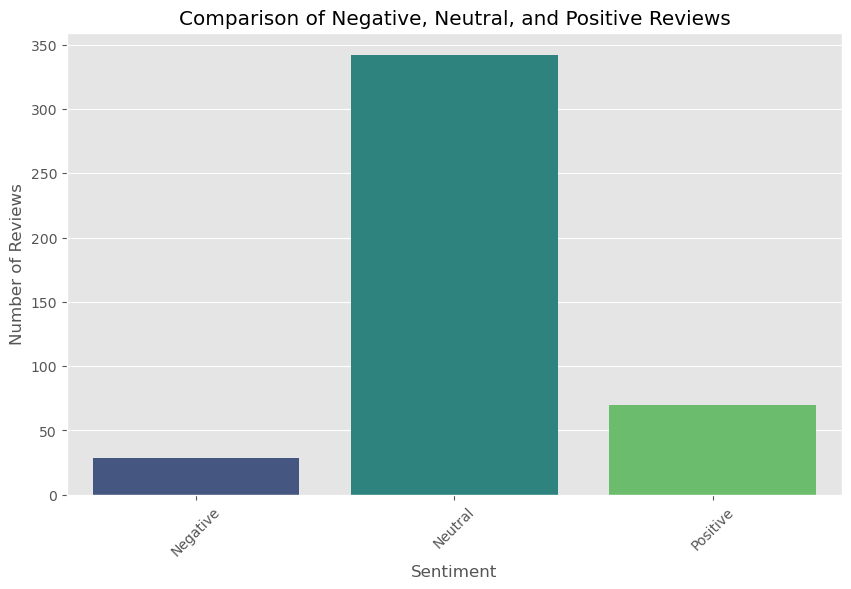

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(data=sentiment_counts, x='Sentiment', y='Count', palette='viridis')
plt.title('Comparison of Negative, Neutral, and Positive Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)  # Rotates labels to prevent overlap
plt.show()

In [16]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)


C:\Users\devio\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [17]:
# print(example)
# sia.polarity_scores(example)

In [18]:
# Run for Roberta Model
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [19]:
res = {}
for i, row in tqdm(df_prepro.iterrows(), total=len(df_prepro)):
    try:
        text = row['MsgBody']
        myid = row['MsgID']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/442 [00:00<?, ?it/s]

In [20]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'MsgID'})
results_df = results_df.merge(df_prepro, how='left')

In [21]:
# Define a function to categorize sentiment scores
def categorize_sentiment(score):
    if score < -0.05:  # Thresholds can be adjusted based on desired sensitivity
        return 'Negative'
    elif score > 0.05:
        return 'Positive'
    else:
        return 'Neutral'
    
# Apply the function to VADER and RoBERTa scores
results_df['vader_sentiment'] = results_df['vader_compound'].apply(categorize_sentiment)
results_df['roberta_sentiment'] = results_df.apply(lambda x: 'Positive' if x['roberta_pos'] > max(x['roberta_neg'], x['roberta_neu']) else 
                                                    ('Negative' if x['roberta_neg'] > max(x['roberta_pos'], x['roberta_neu']) else 'Neutral'), axis=1)

In [22]:
results_df.columns

Index(['MsgID', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'MsgBody',
       'vader_sentiment', 'roberta_sentiment'],
      dtype='object')

In [23]:
results_df.head()

,MsgID,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,MsgBody,vader_sentiment,roberta_sentiment
0,'kyh1ir9',0.000,0.867,0.133,0.3182,0.023593,0.857236,0.119171,much order think go road trip month sure conne...,Positive,Neutral
1,'kyh2b0z',0.000,1.000,0.000,0.0000,0.085847,0.779672,0.134481,go last day deal,Neutral,Neutral
2,'kyh30bd',0.083,0.550,0.367,0.8074,0.108288,0.782975,0.108737,sure try say us fiber gpon cost save passive s...,Positive,Neutral
3,'kyh36dk',0.000,1.000,0.000,0.0000,0.021724,0.911086,0.067191,saw back yard last night tucson,Neutral,Neutral
4,'kyh375z',0.000,0.526,0.474,0.4019,0.018298,0.720238,0.261464,yes starlink us unofficial,Positive,Neutral


In [24]:

results_df.to_csv(file_name + '_with_Sentiments.csv', index=False)

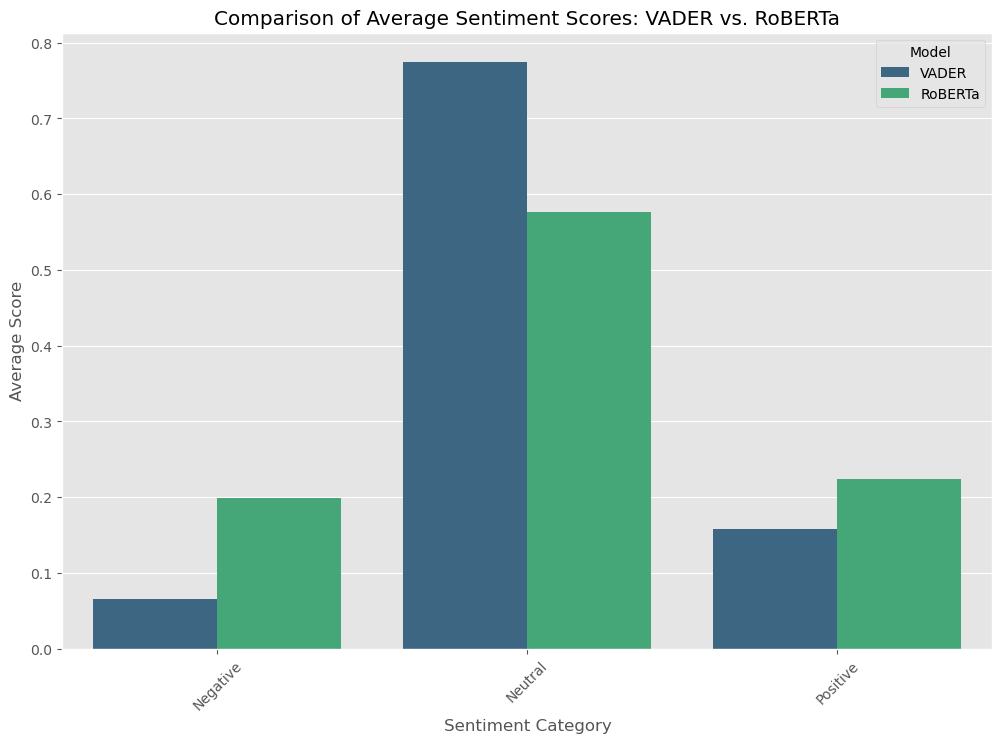

In [25]:
import matplotlib.pyplot as plt

# Calculating average sentiment scores for both VADER and RoBERTa
avg_scores = pd.DataFrame({
    'Sentiment Type': ['VADER', 'VADER', 'VADER', 'RoBERTa', 'RoBERTa', 'RoBERTa'],
    'Sentiment': ['Negative', 'Neutral', 'Positive']*2,
    'Score': [
        results_df['vader_neg'].mean(), 
        results_df['vader_neu'].mean(), 
        results_df['vader_pos'].mean(),
        results_df['roberta_neg'].mean(),
        results_df['roberta_neu'].mean(),
        results_df['roberta_pos'].mean()
    ]
})

# Plotting the comparison
plt.figure(figsize=(12, 8))
sns.barplot(x='Sentiment', y='Score', hue='Sentiment Type', data=avg_scores, palette='viridis')
plt.title('Comparison of Average Sentiment Scores: VADER vs. RoBERTa')
plt.xlabel('Sentiment Category')
plt.ylabel('Average Score')
plt.legend(title='Model')
plt.xticks(rotation=45)
plt.show()

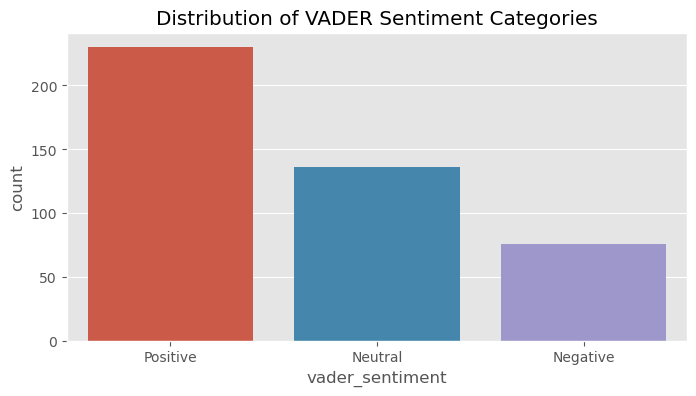

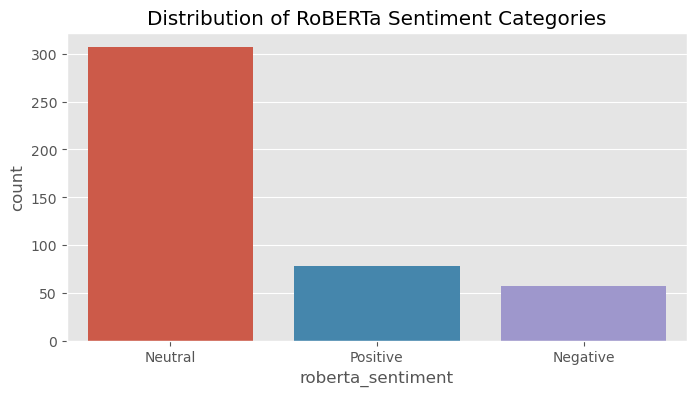

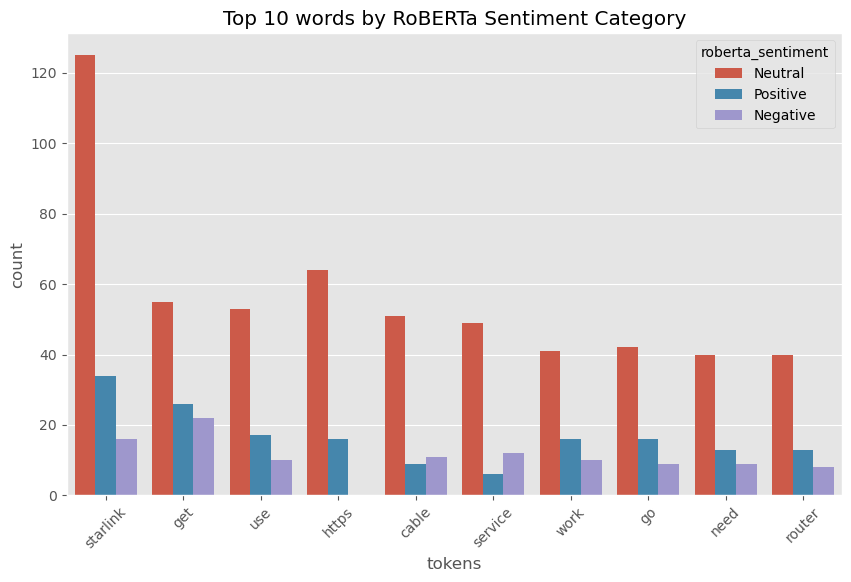

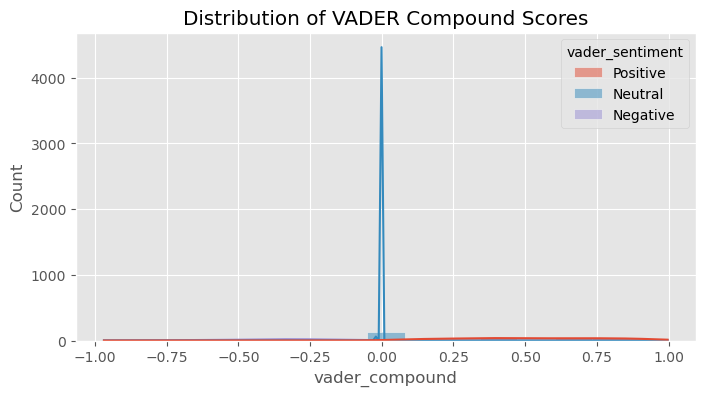

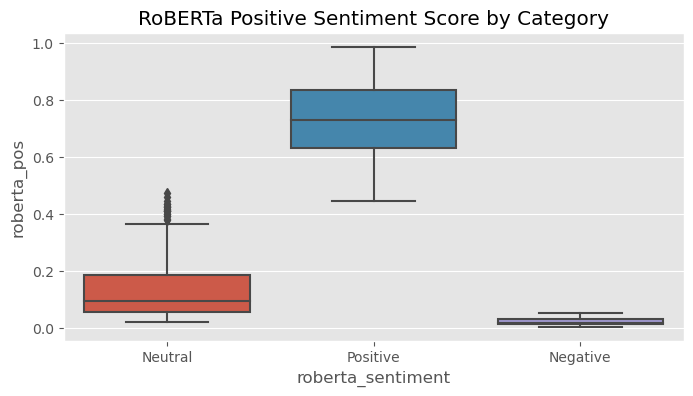

In [26]:
plt.figure(figsize=(8, 4))
sns.countplot(data=results_df, x='vader_sentiment')
plt.title('Distribution of VADER Sentiment Categories')
plt.savefig('vader_sentiment_distribution.png')
plt.show()

# Sentiment Distribution Plot for RoBERTa
plt.figure(figsize=(8, 4))
sns.countplot(data=results_df, x='roberta_sentiment')
plt.title('Distribution of RoBERTa Sentiment Categories')
plt.savefig('roberta_sentiment_distribution.png')
plt.show()

# Assuming 'results_df' has a 'MsgBody' column for the text content
results_df['tokens'] = results_df['MsgBody'].apply(word_tokenize)
results_df_explode = results_df.explode('tokens')

# Word Frequency by RoBERTa Sentiment
plt.figure(figsize=(10, 6))
sns.countplot(data=results_df_explode, x='tokens', hue='roberta_sentiment', order=results_df_explode['tokens'].value_counts().iloc[:10].index)
plt.title('Top 10 words by RoBERTa Sentiment Category')
plt.xticks(rotation=45)
plt.savefig('word_frequency_by_roberta_sentiment.png')
plt.show()

# Sentiment Scores Distribution for VADER Compound
plt.figure(figsize=(8, 4))
sns.histplot(data=results_df, x='vader_compound', kde=True, hue='vader_sentiment')
plt.title('Distribution of VADER Compound Scores')
plt.savefig('vader_compound_scores_distribution.png')
plt.show()

# Box Plot of RoBERTa Sentiment Scores by Category (using 'roberta_pos' as a proxy for positive sentiment score)
plt.figure(figsize=(8, 4))
sns.boxplot(data=results_df, x='roberta_sentiment', y='roberta_pos')
plt.title('RoBERTa Positive Sentiment Score by Category')
plt.savefig('roberta_pos_scores_by_category.png')
plt.show()

In [ ]:
# Create 3 separate dataframes each containing all the Roberts scored Positive, neuaral, and negative comments.

positive_df = results_df[results_df['roberta_sentiment'] == 'Positive'][['MsgID', 'MsgBody', 'roberta_sentiment']]
neutral_df = results_df[results_df['roberta_sentiment'] == 'Neutral'][['MsgID', 'MsgBody', 'roberta_sentiment']]
negative_df = results_df[results_df['roberta_sentiment'] == 'Negative'][['MsgID', 'MsgBody', 'roberta_sentiment']]

pos_df_name = file_name + '_Positive_Roberta.csv'
neu_df_name = file_name + '_Neutral_Roberta.csv'
neg_df_name = file_name + '_Negative_Roberta.csv'
all_df_name = file_name + '_with_Sentiments.csv'

positive_df.to_csv(pos_df_name, index=False)
neutral_df.to_csv(neu_df_name, index=False)
negative_df.to_csv(neg_df_name, index=False)

csv_output_list = [pos_df_name, neu_df_name, neg_df_name, all_df_name]

for i in csv_output_list:
    runLDA(i)
    

Results written to staroutput_Positive_Roberta_LDA_output.txt
Results written to staroutput_Neutral_Roberta_LDA_output.txt
Results written to staroutput_Negative_Roberta_LDA_output.txt
